In [1]:
from tree_partition import sample_uniform_partition_of_tree
import matplotlib.pyplot as plt
import tree_utils as tu
import networkx as nx
from tqdm import tqdm
import pandas as pd
import numpy as np
import math

In [15]:
def make_clique(n):
    return nx.complete_graph(n)

def make_biclique(m, n):
    return nx.complete_bipartite_graph(m, n)

def num_trees_clique(n):
    return n ** (n-2)

def num_snappables_clique(n):
    assert n % 2 == 0
    combo = math.comb(n, int(n/2))
    return combo * (2 / (2 ** n)) * (n ** (n - 2))

def fraction_nears_clique(n, eps):
    first_combo = math.comb(n, int(0.5 * (1 - eps) * n)) # flooring denominator
    second_combo = math.comb(int(0.5 * (1 + eps) * n), int(0.5 * (1 - eps) * n)) # flooring both
    term_1 = eps ** (eps * n)
    term_2 = (1 - eps) ** ((n * (1 - eps)) - 2)
    term_3 = 2 ** (n * (eps - 1))
    return 4 * first_combo * second_combo * term_1 * term_2 * term_3

def fraction_snappables_clique(n):
    return num_snappables_clique(n) / num_trees_clique(n)

def num_trees_biclique(m, n):
    return (m ** (n - 1)) * (n ** (m - 1))

def num_snappables_equal_biclique(n):
    num_edges = (n ** 2) - (2 * n) + 2
    result = 0
    for k in range(1, n): # 1 to n - 1, inclusive
        combo = math.comb(n, k) ** 2
        num_pairs_trees = ((k ** (n - k - 1)) * ((n - k) ** (k - 1))) ** 2
        result += (combo * num_pairs_trees)
    return 0.5 * num_edges * result

def fraction_snappables_equal_biclique(n):
    return num_snappables_equal_biclique(n) / num_trees_biclique(n, n)

In [31]:
eps = 0.05
fraction_nears_clique(400, eps)

0.01652320982427978

In [76]:
def count_snaps(graph, trials, eps=0, viz=True):
    num_snaps = 0
    iterable = tqdm(range(trials)) if viz else range(trials)
    for _ in iterable:
        tree = tu.uniform_random_spanning_tree(graph)
        for node in tree.nodes:
            tree.nodes[node]['pop'] = 1
        min_part_size = (len(tree) * (1 - eps)) / 2
        max_part_size = (len(tree) * (1 + eps)) / 2
        _, num_balance_edges = sample_uniform_partition_of_tree(tree, 2, min_part_size, max_part_size, "pop")
        if num_balance_edges:
            num_snaps += 1
    return num_snaps / trials

In [96]:
N = 4
num_trials = 100000
graph = make_biclique(N, N)

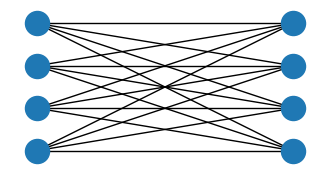

In [97]:
fig, ax = plt.subplots(figsize=(4,2))
left_set, right_set = nx.bipartite.sets(graph)

nx.draw(graph, pos=nx.bipartite_layout(graph, left_set), ax=ax)

In [98]:
proportion = count_snaps(graph, num_trials)

100%|█████████████████████████████████| 100000/100000 [00:19<00:00, 5194.45it/s]


In [99]:
proportion

0.60085

In [100]:
fraction_snappables_equal_biclique(N)

0.7421875

In [101]:
# the above fractions should be basically equal!!! see the clique example below which is equal...

In [56]:
N = 200
eps = 0.01
num_trials = 10000
graph = make_clique(N)

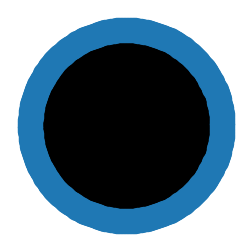

In [57]:
fig, ax = plt.subplots(figsize=(3,3))
nx.draw_circular(graph, ax=ax)

In [58]:
proportion = count_snaps(graph, num_trials, eps=eps)

100%|████████████████████████████████████| 10000/10000 [00:40<00:00, 249.63it/s]


In [ ]:
proportion

0.2375

In [ ]:
fraction_snappables_clique(N)

0.2507413752391585

In [165]:
%%time
epsilons = [0.5, 0.1, 0.001, 0.00001]
Ns = [4, 16, 128, 256, 1024]
num_trials = 10000

data = {}
for eps in epsilons:
    print(eps)
    fractions = []
    for N in Ns:
        graph = make_clique(N)
        fraction = count_snaps(graph, num_trials, eps=eps, viz=True)
        fractions.append(fraction)
    data[eps] = fractions

0.5


100%|█████████████████████████████████████| 10000/10000 [06:57<00:00, 23.96it/s]


0.1


100%|█████████████████████████████████████| 10000/10000 [06:06<00:00, 27.31it/s]


0.001


100%|█████████████████████████████████████| 10000/10000 [06:02<00:00, 27.61it/s]


1e-05


100%|█████████████████████████████████████| 10000/10000 [05:50<00:00, 28.54it/s]

CPU times: user 30min 20s, sys: 34.6 s, total: 30min 55s
Wall time: 31min


In [166]:
df = pd.DataFrame(data)
df.index = Ns

In [167]:
df

,0.50000,0.10000,0.00100,0.00001
4,0.7518,0.7547,0.7557,0.7556
16,0.9998,0.3989,0.3984,0.4030
128,1.0000,0.6714,0.1431,0.1417
256,1.0000,0.6709,0.0974,0.1025
1024,1.0000,0.7132,0.0501,0.0500


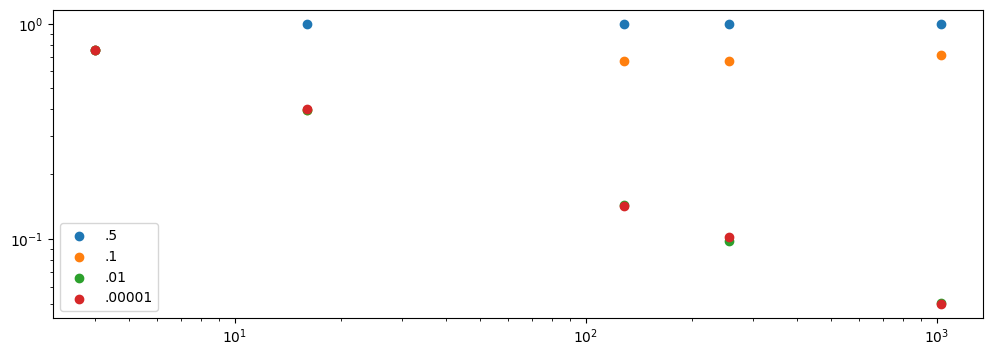

In [168]:
# with plt.xkcd():
fig, ax = plt.subplots(figsize=(12,4))
plt.scatter(df.index, df[0.5], label=".5")
plt.scatter(df.index, df[0.10000], label=".1")
plt.scatter(df.index, df[0.00100], label=".01")
plt.scatter(df.index, df[0.00001], label=".00001")
plt.xscale("log")
plt.yscale("log")
_ = plt.legend()

In [170]:
tf = df.T
tf

,4,16,128,256,1024
0.50000,0.7518,0.9998,1.0000,1.0000,1.0000
0.10000,0.7547,0.3989,0.6714,0.6709,0.7132
0.00100,0.7557,0.3984,0.1431,0.0974,0.0501
0.00001,0.7556,0.4030,0.1417,0.1025,0.0500


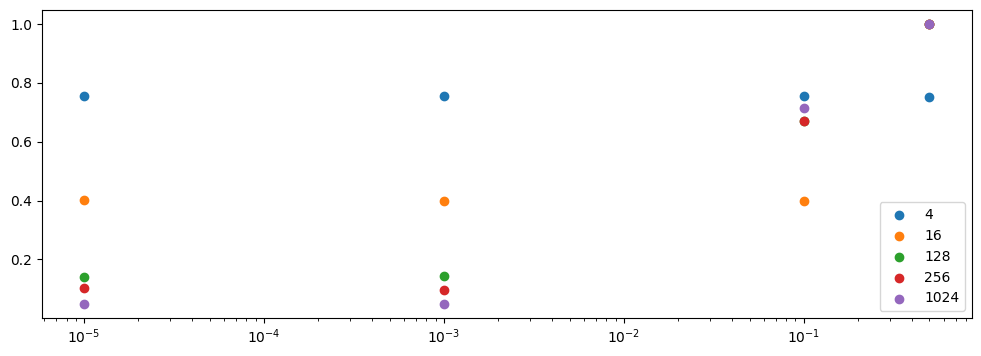

In [171]:
fig, ax = plt.subplots(figsize=(12,4))
tf = df.T

for N in Ns:
    plt.scatter(tf.index, tf[N], label=N)

plt.xscale("log")
_ = plt.legend()